Finally, a colab notebook :) based almost entirely on [this](https://github.com/mechanistic-interpretability-grokking/progress-measures-paper/blob/main/Grokking_Analysis.ipynb)
# Setup
A collection of helper functions and setup code, and all the models written everywhere

In [2]:
# Basic imports
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import numpy as np

from collections import defaultdict
import random
from pathlib import Path
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import DataLoader, TensorDataset

from models.mlp_grok import MLP as MLP_GROK
from train.mlp_grok_train import cross_entropy_high_precision, gen_train_test

device = t.device("cuda" if t.cuda.is_available() else "cpu")

### Helper Functions

Logging, or using plotly for the first time

In [36]:
def heatmap(x, title):
    fig, ax = plt.subplots()
    im = ax.imshow(x)
    ax.set_xticks(np.arange(start=0, stop=x.shape[0], step=10))
    ax.set_yticks(np.arange(start=0, stop=x.shape[1], step=10))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

# Model Analysis Setup

Loads the model snapshot to analyse, and define some helper variables

## Loading Model

In [3]:
p = 113
fn = lambda x, y: (x + y) % p
d_model = 64
d_vocab = p

model = MLP_GROK(d_vocab, d_model)
chkpt = t.load('train/checkpoints/mlp_grok/mlp_grok_final_1.pt')
model.to(device)

MLP(
  (embed): Embed()
  (layer0): Linear(in_features=128, out_features=128, bias=False)
  (layer1): Linear(in_features=128, out_features=64, bias=False)
  (unembed): UnEmbed()
  (hook0): HookPoint()
  (hook1): HookPoint()
  (hook2): HookPoint()
  (hook3): HookPoint()
)

In [4]:
W_E = model.embed.W_E
W_in = model.layer0.weight
W_out = model.layer1.weight
W_U = model.unembed.W_U

print("W_E", W_E.shape)
print("W_in", W_in.shape)
print("W_out", W_out.shape)
print("W_U", W_U.shape)

W_E torch.Size([64, 113])
W_in torch.Size([128, 128])
W_out torch.Size([64, 128])
W_U torch.Size([64, 113])


In [43]:
# Sample all the activations, all of them
cache = {}

def hook_fn(act, name):
    cache[name] = act

for n in model.named_children():
    if 'hook' in n[0]:
        n[1].add_hook(hook_fn)

train_pairs, _ = gen_train_test(1, p, seed=1)
train_pairs_ds = TensorDataset(
    t.tensor([t[0] for t in train_pairs], dtype=t.long),
    t.tensor([t[1] for t in train_pairs], dtype=t.long),
)
train_loader = DataLoader(train_pairs_ds, batch_size=len(train_pairs), num_workers=2)
for i, (data, _) in enumerate(train_loader):
    data = data.to(device)
    model(data)

for n in model.named_children():
    if "hook" in n[0]:
        n[1].remove_hooks()

In [44]:
for k, v in cache.items():
    print(k, v.shape)

embed torch.Size([12769, 2, 64])
layer0 torch.Size([12769, 128])
layer1 torch.Size([12769, 64])
unembed torch.Size([12769, 113])


In [45]:
logits = cache['unembed'][:, -1] 
neuron_acts_post = cache['layer1'][:, -1]
neuron_acts_pre = cache['layer0'][:, -1]

### Ideas for how model does this
The initial idea I have for this is the following: 

- Each number is mapped to a rotation matrix, 
- After concatentation, the representation is multipled in the MLPs, - This will yield the rotation matrix of the answer which the unembed just reverses

Note to self: functions that look periodic in the original basis are sparse in the fourier basis

Unfortunately, I have run out of time to actually do interpretability on this :(, will show periodicity for now and maybe extend in the future

### Fourier Helper

In [46]:
fourier_basis = []
fourier_basis.append(t.ones(p)/np.sqrt(p))
fourier_basis_names = ['Const']
# Note that if p is even, we need to explicitly add a term for cos(kpi), ie 
# alternating +1 and -1
for i in range(1, p//2 +1):
    fourier_basis.append(t.cos(2*t.pi*t.arange(p)*i/p))
    fourier_basis.append(t.sin(2*t.pi*t.arange(p)*i/p))
    fourier_basis[-2]/=fourier_basis[-2].norm()
    fourier_basis[-1]/=fourier_basis[-1].norm()
    fourier_basis_names.append(f'cos {i}')
    fourier_basis_names.append(f'sin {i}')
fourier_basis = t.stack(fourier_basis, dim=0).to(device)

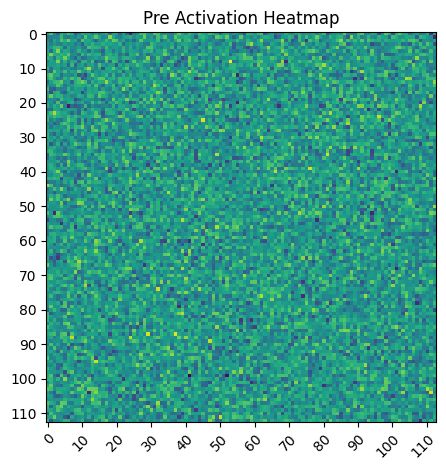

In [47]:
neuron_acts_pre = neuron_acts_pre - neuron_acts_pre.mean(dim=0)
neuron_acts_pre = einops.rearrange(neuron_acts_pre, '(x y) ... -> x y ...', x=p, y=p)
heatmap(neuron_acts_pre.detach().numpy(), "Pre Activation Heatmap")

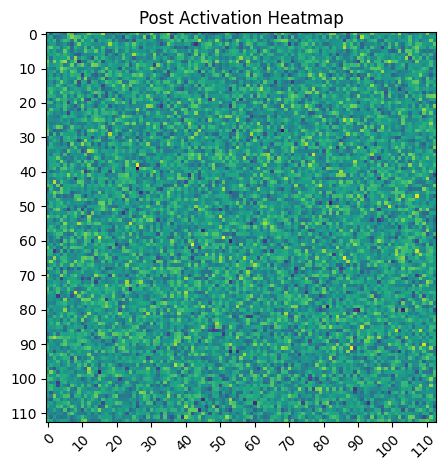

In [48]:

neuron_acts_post = neuron_acts_post - neuron_acts_post.mean(dim=0)
neuron_acts_post = einops.rearrange(neuron_acts_post, '(x y) ... -> x y ...', x=p, y=p)
heatmap(neuron_acts_post.detach().numpy(), "Post Activation Heatmap")